In [122]:
# fmt: off

### Necessary Imports & Functions

In [123]:
import numpy as np
from matplotlib import ticker

from rtdip_sdk.pipelines.data_quality import KSigmaAnomalyDetection, IntervalFiltering, ArimaPrediction, MissingValueImputation, NormalizationMean, NormalizationZScore, NormalizationMinMax, Denormalization, DuplicateDetection, data_manipulation, IdentifyMissingDataPattern
from rtdip_sdk.pipelines.machine_learning import LinearRegression
from rtdip_sdk.pipelines.transformers.spark.machine_learning.columns_to_vector import ColumnsToVector
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import math
import random

# Hide every warning
import warnings
# Comment first line for developement, comment second line for presentation
#warnings.filterwarnings('ignore')
warnings.filterwarnings('default')

spark_session = SparkSession.builder.master("local[2]").appName("test").getOrCreate()


In [124]:
# Wrapper function for creating a plot with PyPlotLib
def create_value_plot(value_df = None, secondary_value_df = None, title = 'Unnamed Plot', x_label = 'Index', y_label = 'Primary Label', secondary_y_label = 'Secondary Value', share_y_axis = False, xlim = None, ylim = None, y_sec_lines = None, linestyle = '--', grid = 'y'):
    value_df.index = pd.to_datetime(value_df['EventTime'], format='mixed')
    value_df = value_df['Value']
    if secondary_value_df is not None:
        secondary_value_df.index = pd.to_datetime(secondary_value_df['EventTime'], format='mixed')
        secondary_value_df = secondary_value_df['Value']

    fig, ax = plt.subplots()
    ax.plot(value_df, linestyle, linewidth=2)
    ax.set_xlabel(x_label)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y \n %H:%M:%S"))
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_ylim([value_df.min(), value_df.max()] if ylim is None else ylim)
    ax.set_xlim([value_df.index.min(), value_df.index.max()] if xlim is None else xlim)
    if grid is not None:
        ax.grid(axis=grid)
    else:
        ax.grid(False)

    if secondary_value_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(secondary_y_label, color=color)
        ax2.plot(secondary_value_df, linestyle, color=color, linewidth=1,)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim(ax.get_ylim() if share_y_axis else [secondary_value_df.min(), secondary_value_df.max()])
        ax2.set_xlim(ax.get_xlim())
        if y_sec_lines is not None:
            for y_sec_line in y_sec_lines:
                ax2.axhline(y_sec_line, color= 'gray', linestyle = linestyle, linewidth=2)


    fig.tight_layout()
    plt.show()
    plt.clf()

# Adds artificial spikes to data
def add_extreme_spikes(value_df, entries_to_spike=25):
    random.seed(0)
    samples = value_df.sample(n=entries_to_spike, random_state=1)
    mask = value_df.index.isin(samples.index)
    value_df.loc[mask, 'Value'] = value_df.loc[mask, 'Value'].apply(lambda x: x + 5.0 if random.random() < 0.5 else x - 5.0)
    return value_df

# Duplicate data points artificially in data
def add_duplicate_data(value_df, entries_to_duplicate=25):
    random.seed(0)
    samples = value_df.head(n=entries_to_duplicate)
    value_df = pd.concat([value_df, samples])
    return value_df


### Introduction

I'm [insert name], a Data Engineer at Shell. In the following presentation, we are going to showcase the RTDIP Pipeline, which can be used to easily analyse heterogeneous Big Data. This is done by pre-processing and analysing some data which was recorded from a collection of sensors located at refineries or other facilities by Shell.

### Source of Data
The first plot shows all the data contained in the file. For sake of brevity, we will only analyse a specific subset of the data shown in the second plot.

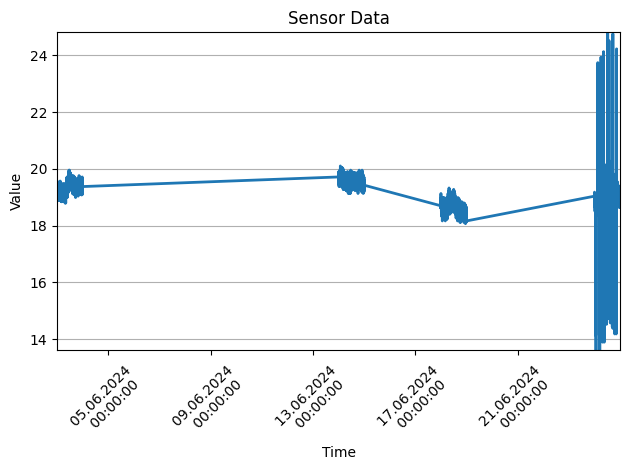

<Figure size 640x480 with 0 Axes>

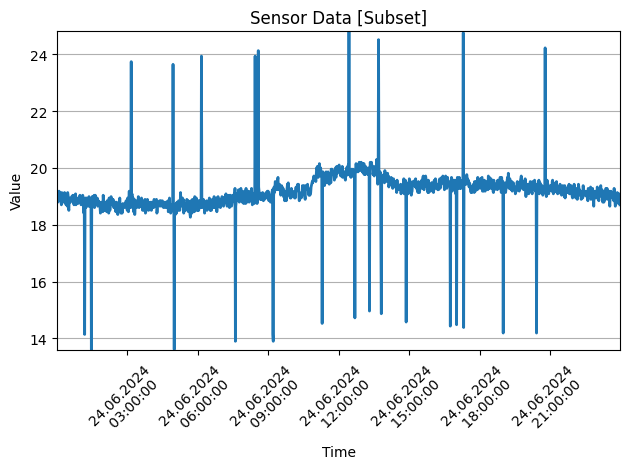

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:485: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


<Figure size 640x480 with 0 Axes>

In [125]:
# Load & prepare data for usage by filtering to single source and converting columns to correct type
source_df = pd.read_pickle('./ExampleData.pkl')
tagname_to_select = '.0MI22YDSAXA3E0:S20'
source_df = source_df[source_df['TagName'] == tagname_to_select]
source_df['EventTime'] = pd.to_datetime(source_df['EventTime'], format='mixed')
source_df = source_df.sort_values(by='EventTime')
source_df.index = source_df['EventTime']
full_source_df = source_df

start_time = pd.to_datetime('2024-06-24 0:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-25 0:00:00', format='%Y-%m-%d %X')
source_df = source_df[start_time:end_time]

source_df = add_extreme_spikes(source_df)
source_df = add_duplicate_data(source_df)
source_df = source_df.sort_index()

full_source_df = pd.concat([full_source_df.loc[:start_time], source_df[start_time:end_time], full_source_df.loc[end_time:]], axis=0)

# We plot here the whole data range of one source
create_value_plot(full_source_df, title='Sensor Data', y_label='Value', x_label='Time', linestyle='-')
create_value_plot(source_df, title='Sensor Data [Subset]', y_label='Value', x_label='Time', linestyle='-')

df_0 = spark_session.createDataFrame(source_df, ['TagName', 'EventTime', 'Status', 'Value'])

### Normalization
First the data is normalised, which is useful for further preprocessing & potential machine learning applications. We will process the whole data through the pipeline in normalised form and can denormalize it back to its original form at the of it. That the normalisation only changes the scale of the data and not its shape is shown in the following plot. Note the different axis range on the left and right side of the plot.

In [126]:
# Prepare Pipeline Compoment
z_score_norm = NormalizationZScore(df=df_0, column_names=['Value'], in_place=True)
# Execute the normalization on the dataframe
df_1 = z_score_norm.filter()

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 53682), raddr=('127.0.0.1', 37789)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 33212), raddr=('127.0.0.1', 37263)>
  self._sock = None


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 42514), raddr=('127.0.0.1', 36779)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/t

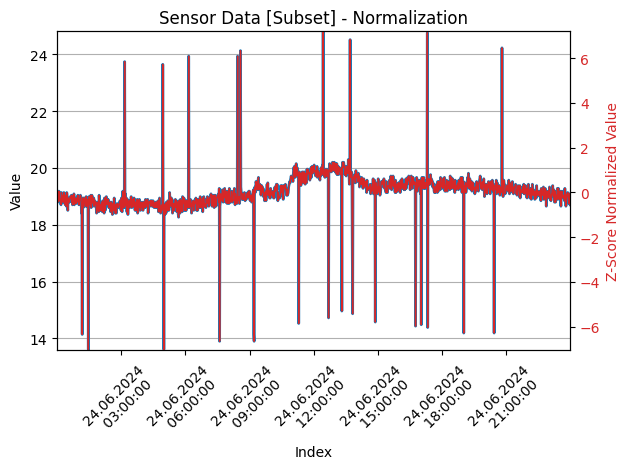

<Figure size 640x480 with 0 Axes>

In [127]:
create_value_plot(value_df=df_0.toPandas(), secondary_value_df=df_1.toPandas(), title='Sensor Data [Subset] - Normalization', y_label = 'Value',  secondary_y_label='Z-Score Normalized Value', linestyle='-', grid='y')

### Duplicate Detection
*Scenario*:
In datasets, some datapoints could be duplicated because of communication errors or sensor errors. Cleaning these will decrease the size of the dataframe without losing any information.


In [128]:
print('Before Duplicate Removal')
df_1.filter('EventTime = "2024-06-24 00:00:31.212"').show(10, False)
random.seed(0)
df_2 = DuplicateDetection(df=df_1, primary_key_columns=['EventTime']).filter()
print('After Duplicate Removal')
df_2.filter('EventTime = "2024-06-24 00:00:31.212"').show(10, False)


Before Duplicate Removal
+-------------------+-----------------------+------+--------------------+
|TagName            |EventTime              |Status|Value               |
+-------------------+-----------------------+------+--------------------+
|.0MI22YDSAXA3E0:S20|2024-06-24 00:00:31.212|Good  |-0.12844665214317183|
|.0MI22YDSAXA3E0:S20|2024-06-24 00:00:31.212|Good  |-0.12844665214317183|
+-------------------+-----------------------+------+--------------------+

After Duplicate Removal
+-------------------+-----------------------+------+--------------------+
|TagName            |EventTime              |Status|Value               |
+-------------------+-----------------------+------+--------------------+
|.0MI22YDSAXA3E0:S20|2024-06-24 00:00:31.212|Good  |-0.12844665214317183|
+-------------------+-----------------------+------+--------------------+



### Sigma Anomaly Detection
In raw sensor data, there are sometimes measurement outliers or errors, which pollute the data.
Identifying these spikes and removing them improves the data quality.

In [129]:
random.seed(0)
# Execute Pipeline
df_3 = KSigmaAnomalyDetection(spark_session, df=df_2, column_names=['Value'], k_value=2.0, use_median=False).filter()

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 55040), raddr=('127.0.0.1', 45277)>
  self._sock = None


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 33896), raddr=('127.0.0.1', 45377)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/t

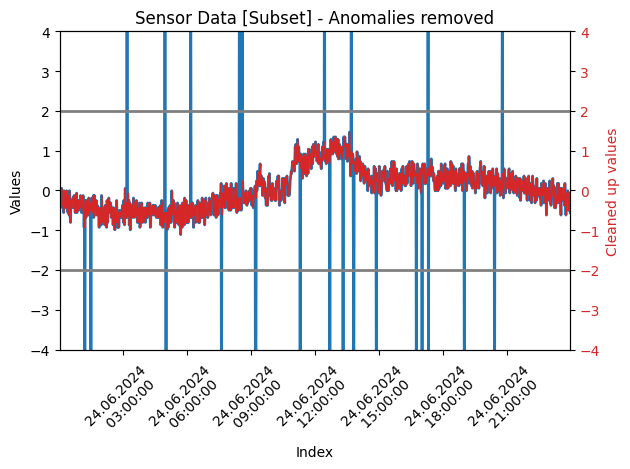

<Figure size 640x480 with 0 Axes>

In [130]:
# Transform Data back into pandas
create_value_plot(value_df=df_2.toPandas(), secondary_value_df=df_3.toPandas(), title='Sensor Data [Subset] - Anomalies removed', share_y_axis=True, y_label = 'Values', secondary_y_label='Cleaned up values', ylim=[-4, 4], y_sec_lines = [-2.0, 2.0], linestyle='-', grid=None)

### Value Imputation
*Scenario*:
Sometimes some data points is missing or the time differences between two neighbouring datapoints is too large to be processed effectively. To fix that issue, Value Imputation is used to fill in these gaps with meaningful values. This is necessary in some situations, where the following components expects a dataset with regularly spaced interval between teo neighbouring points.



In [131]:
random.seed(0)
# Execute Pipeline
start_time = pd.to_datetime('2024-06-24 3:00:00', format='%Y-%m-%d %X')
end_time = pd.to_datetime('2024-06-24 4:00:00', format='%Y-%m-%d %X')
# Slicing by end dates is only possible if index is sorted by time
# df_3_gap = df_3.filter(F.col('EventTime').between(start_time, end_time))
# df_4 = df_3.join(df_3_gap, on='EventTime', how='left_anti')
# df_4_gap = MissingValueImputation(spark_session, df=df_3_gap, tolerance_percentage=10).filter()
# df_4 = df_4.unionByName(df_4_gap).sort(['EventTime'])
df_4 = MissingValueImputation(spark_session, df=df_3, tolerance_percentage=1).filter()
# df_4.show()

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 42050), raddr=('127.0.0.1', 42785)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 59804), raddr=('127.0.0.1', 35991)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 54064), raddr=('127.0.0.1', 46005)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 41424), raddr=('127.0.0.1', 33719)>
  self._sock = N

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 53062), raddr=('127.0.0.1', 45247)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/t

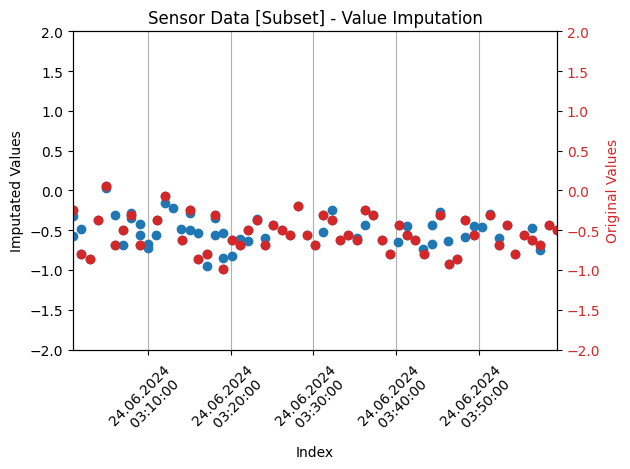

1895


/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 52114), raddr=('127.0.0.1', 37951)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/t

<Figure size 640x480 with 0 Axes>

In [132]:
df_3_pd = df_3.toPandas().set_index('EventTime', drop=False)
df_4_pd = df_4.toPandas().set_index('EventTime', drop=False)
# Transform Data back into pandas
create_value_plot(value_df=df_4_pd[start_time:end_time], secondary_value_df=df_3_pd[start_time:end_time], title='Sensor Data [Subset] - Value Imputation', share_y_axis=True, y_label = 'Imputated Values', secondary_y_label='Original Values', ylim=[-2.0, 2.0], linestyle='o', grid='x')
print(df_4.toPandas().shape[0])

### ARIMA Prediction
*Scenario*:
We want to predict how the signal continues after the end of data. For that we will train an ARIMA-forecasting-model on the hundred last points and predict 100 more points from that sample. The ARIMA Model generated good forecast if good parameters are supplied to the model.

In [133]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
df_5_a = ArimaPrediction(past_data=df_4, to_extend_name=tagname_to_select, number_of_data_points_to_analyze=100, number_of_data_points_to_predict=100,
                             order=(3,0,1), seasonal_order=(2,1,1,50), trend='n').filter()

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 39468), raddr=('127.0.0.1', 38681)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/t

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 51772), raddr=('127.0.0.1', 43275)>
  self._sock = None


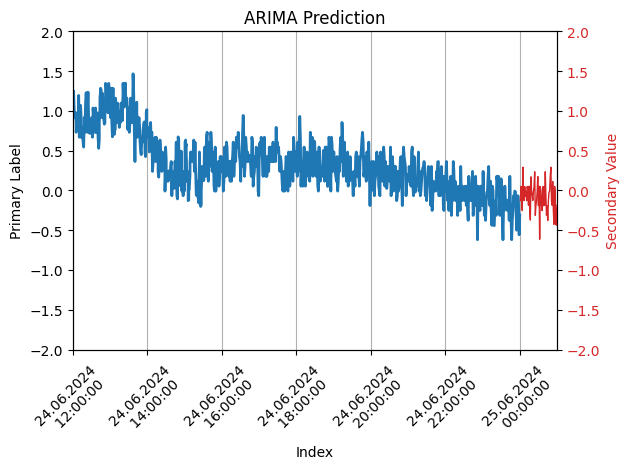

<Figure size 640x480 with 0 Axes>

In [134]:
df_5_a_pd = df_5_a.toPandas()
df_5_a_pd['EventTime'] = pd.to_datetime(df_5_a_pd['EventTime'], format='mixed')
df_5_a_pd = df_5_a_pd.set_index('EventTime', drop=False)
df_5_a_pd['Value'] = pd.to_numeric(df_5_a_pd['Value'])
plot_begin_time = pd.to_datetime('2024-06-24 12:00:00', format='%Y-%m-%d %X')
plot_split = pd.to_datetime('2024-06-25 0:00:00', format='%Y-%m-%d %X')
plot_end_time = pd.to_datetime('2024-06-25 1:00:00', format='%Y-%m-%d %X')
create_value_plot(value_df=df_5_a_pd[plot_begin_time:plot_split], secondary_value_df=df_5_a_pd[plot_split:plot_end_time], share_y_axis=True,
                    ylim=(-2, 2), title='ARIMA Prediction', xlim=[plot_begin_time, plot_end_time], linestyle='-', grid='x')

### Linear Regression
-- NOT DONE YET, SINCE THE AMOUNT OF POINTS TO FORECAST CANT BE SET --

In [135]:
# Reuse Output Dataframe from Interval Filtering, since that reduces amount of points needed to a manageable amount
df_4_vec = ColumnsToVector(df=df_4, input_cols=["Value"], output_col="features").transform()

df_4_vec_pd = df_4_vec.toPandas()

linear_regression = LinearRegression(
        df_4_vec,
        features_col="features",
        label_col="Value",
        prediction_col="prediction",
    )

model = linear_regression.train(df_4_vec)
df_5_b = model.predict(df_4_vec)
df_5_b_pd = df_5_b.toPandas()

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 59506), raddr=('127.0.0.1', 41389)>
  self._sock = None
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/t

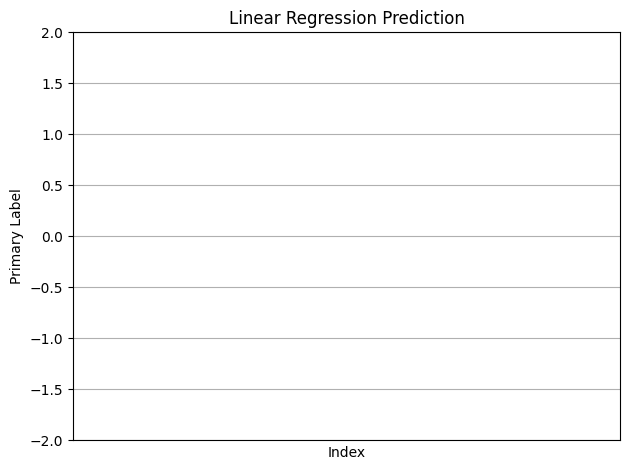

<Figure size 640x480 with 0 Axes>

In [136]:


df_5_b_pd['Value'] = df_5_b_pd['Value'].fillna(df_5_b_pd['prediction'])
df_5_b_pd['Value'] = pd.to_numeric(df_5_a_pd['Value'])
df_5_b_pd = df_5_b_pd.drop(['prediction', 'features'], axis=1)
plot_start_time = pd.to_datetime('2024-06-24 10:30:00', format='%Y-%m-%d %X')
plot_end_time = pd.to_datetime('2024-06-24 11:30:00', format='%Y-%m-%d %X')
create_value_plot(value_df=df_5_b_pd, share_y_axis=True,
                    ylim=(-2, 2), title='Linear Regression Prediction')

### Denormalization
After we processed the data in our pipeline, the data is denormalized back to its real values. This is done by providing a reference to the normalizing component to the denormalizer. After the denormalization, the data could be further used for Machine Learning or Manual Data Analysis.

In [137]:
# Prepare Pipeline Compoment
z_score_denorm = Denormalization(df=df_5_a, normalization_to_revert=z_score_norm)
# Execute the normalization on the dataframe
df_6 = z_score_denorm.filter()

/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/site-packages/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
/home/timm638/miniconda3/envs/amos2024ws01-rtdip-data-quality-checker/lib/python3.11/socket.py:777: ResourceWarning: unclosed <socket.socket fd=74, family=2, type=1, proto=6, laddr=('127.0.0.1', 41754), raddr=('127.0.0.1', 37845)>
  self._sock = None


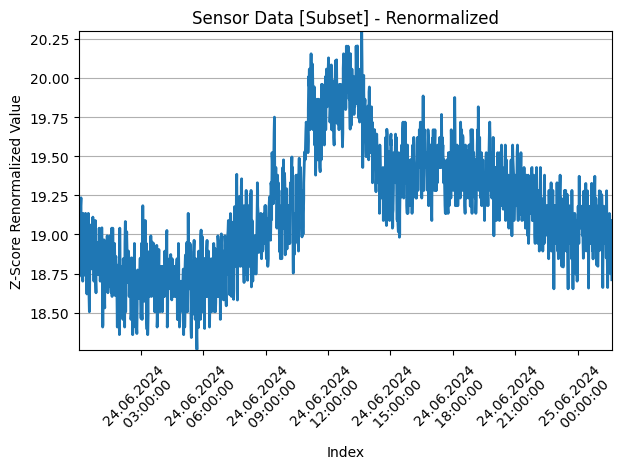

<Figure size 640x480 with 0 Axes>

In [138]:
create_value_plot(value_df=df_6.toPandas(), title='Sensor Data [Subset] - Renormalized', y_label = 'Z-Score Renormalized Value', linestyle='-')